# CAB_420-A2: Enron Email Sender Identification

# 1. Imports and Functions

In [15]:
# Imports
# pip install -r requirements.txt

# to set up the venv, run
# pip install keras matplotlib seaborn scikit-learn scikit-image statsmodels opencv-python pandas gensim pillow tensorflow-datasets xgboost jupyter ipython jupyterlab openpyxl


# Imports
import tarfile
import os
import sys
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import hashlib

from tqdm.notebook import tqdm
from collections import namedtuple, Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

print("All imports successful!")

All imports successful!


In [5]:
# Constants
tar_path = 'enron_mail_20150507.tar.gz'
data_path = 'maildir'
Email = namedtuple('Email', ['from_', 'message'])
max_emails = 500 # Senders will stop having emails appended to their dataset once this number is reached
min_emails = 200 # Minimum emails a class must have to be kept
min_words = 20 # Minimum words an email needs to have to be kept
# max_words = 200 # Max words an email needs to have to be kept
le = LabelEncoder()

# Functions
# Decrypts tar file
def decrypt_tar(file_path):
    # Decrypt tar.zg file
    if not os.path.isdir(data_path):
        try:
            with tarfile.open(file_path, 'r:gz') as tar:
                members = tar.getmembers()
                for member in tqdm(members, desc="Extracting files"):
                    tar.extract(member)

           # delete archive after extraction
           # os.remove(file_path)
           # print(f"Deleted archive: {file_path}")
        except:
            print(f"File '{file_path}' does not exist.")
            return None
    else:
        print(f"Folder '{data_path}' already exists.")
        return None


# Adapted from https://www.youtube.com/watch?v=_hkmSGG9pyA (Pythonic Accountant on YouTube)
# Takes all individual email files and returns them in Email objects that have referenceable sections
def get_msg(file_path):
    try:
        with open(file_path, 'r', encoding='latin1') as f:
            from_ = ''
            message = []
            in_message = False

            content = f.read().replace('\r', '')
            lines = content.split('\n')

            for line in lines:
                if line.startswith('From:') and not from_:
                    from_ = line.replace('From:', '').strip()
                elif line.startswith('X-FileName:'):
                    in_message = True
                elif in_message:
                    # Skip quoted replies (email forwards)
                    if line.strip().lower().startswith('-----Original Message-----'):
                        break
                    message.append(line)

            return Email(
                from_=from_,
                message=' '.join(message).strip()
            )

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None


# Filters out all classes with less than the minimum samples
def filter_classes(x, y):
    # First pass: apply filters
    sender_counts = Counter(y)
    x_temp = []
    y_temp = []

    for xi, yi in zip(x, y):
        xj = preprocess(xi)
        if (
            sender_counts[yi] >= min_emails and
            len(xj.split()) > min_words and
            'enron' in yi.lower()
        ):
            x_temp.append(xj)
            y_temp.append(yi)

    # Second pass: drop entries that dont fit the min-max_email thresholds
    filtered_counts = Counter(y_temp)
    x_filtered = []
    y_filtered = []

    for xi, yi in zip(x_temp, y_temp):
        if filtered_counts[yi] >= min_emails and filtered_counts[yi] <= max_emails:
            x_filtered.append(xi)
            y_filtered.append(yi)

    count_filtered = Counter(y_filtered)
    print(f"Filtered: {len(x_filtered)} emails from {len(set(y_filtered))} users")
    return x_filtered, y_filtered, count_filtered


# Extracts all emails from the maildir file.
def load_directory(maildir_path):
    x = []
    y = []

    for root, dirs, files in os.walk(maildir_path):
        for email_file in files:
            file_path = os.path.join(root, email_file)

            # Skip directories (until a file is hit)
            if not os.path.isfile(file_path):
                continue

            # Open file, parse contents, and add to x/y arrays
            try:
                email = get_msg(file_path)
                # Only keep emails that have a from and message
                if email and email.from_ and email.message:
                    x.append(email.message)
                    y.append(email.from_)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    count = Counter(y)
    print('Unfiltered data loaded')
    return(x, y, count)


# Process email body data
def preprocess(text):
    text = text.lower()

    # Strip out email addresses and URLs
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return(text)

# 2. Loading and Pre-Processing

In [6]:
# Extract tar file
decrypt_tar(tar_path)

Folder 'maildir' already exists.


In [7]:
# Load and filter data
# This section may take a while, wait for print below
x, y, count = load_directory(data_path)
x_filtered, y_filtered, count_filtered = filter_classes(x, y)

Unfiltered data loaded
Filtered: 47151 emails from 152 users


Unfiltered: 517401 emails from 20328 users
Filtered:   47151 emails from 152 users with 200-500 emails

Filtered senders (152):
mark.schroeder@enron.com: 493 emails
dutch.quigley@enron.com: 488 emails
legal <.taylor@enron.com>: 482 emails
chris.stokley@enron.com: 475 emails
janette.elbertson@enron.com: 473 emails
miyung.buster@enron.com: 471 emails
leonardo.pacheco@enron.com: 456 emails
kay.chapman@enron.com: 455 emails
tim.belden@enron.com: 453 emails
rob.gay@enron.com: 453 emails
shona.wilson@enron.com: 447 emails
jane.tholt@enron.com: 446 emails
joe.parks@enron.com: 443 emails
randall.gay@enron.com: 443 emails
v.weldon@enron.com: 442 emails
cheryl.nelson@enron.com: 439 emails
joseph.alamo@enron.com: 433 emails
amy.fitzpatrick@enron.com: 431 emails
andrea.ring@enron.com: 431 emails
exchange.administrator@enron.com: 430 emails
kevin.ruscitti@enron.com: 430 emails
j..kean@enron.com: 429 emails
w..white@enron.com: 428 emails
monika.causholli@enron.com: 425 emails
public.relations@enron.

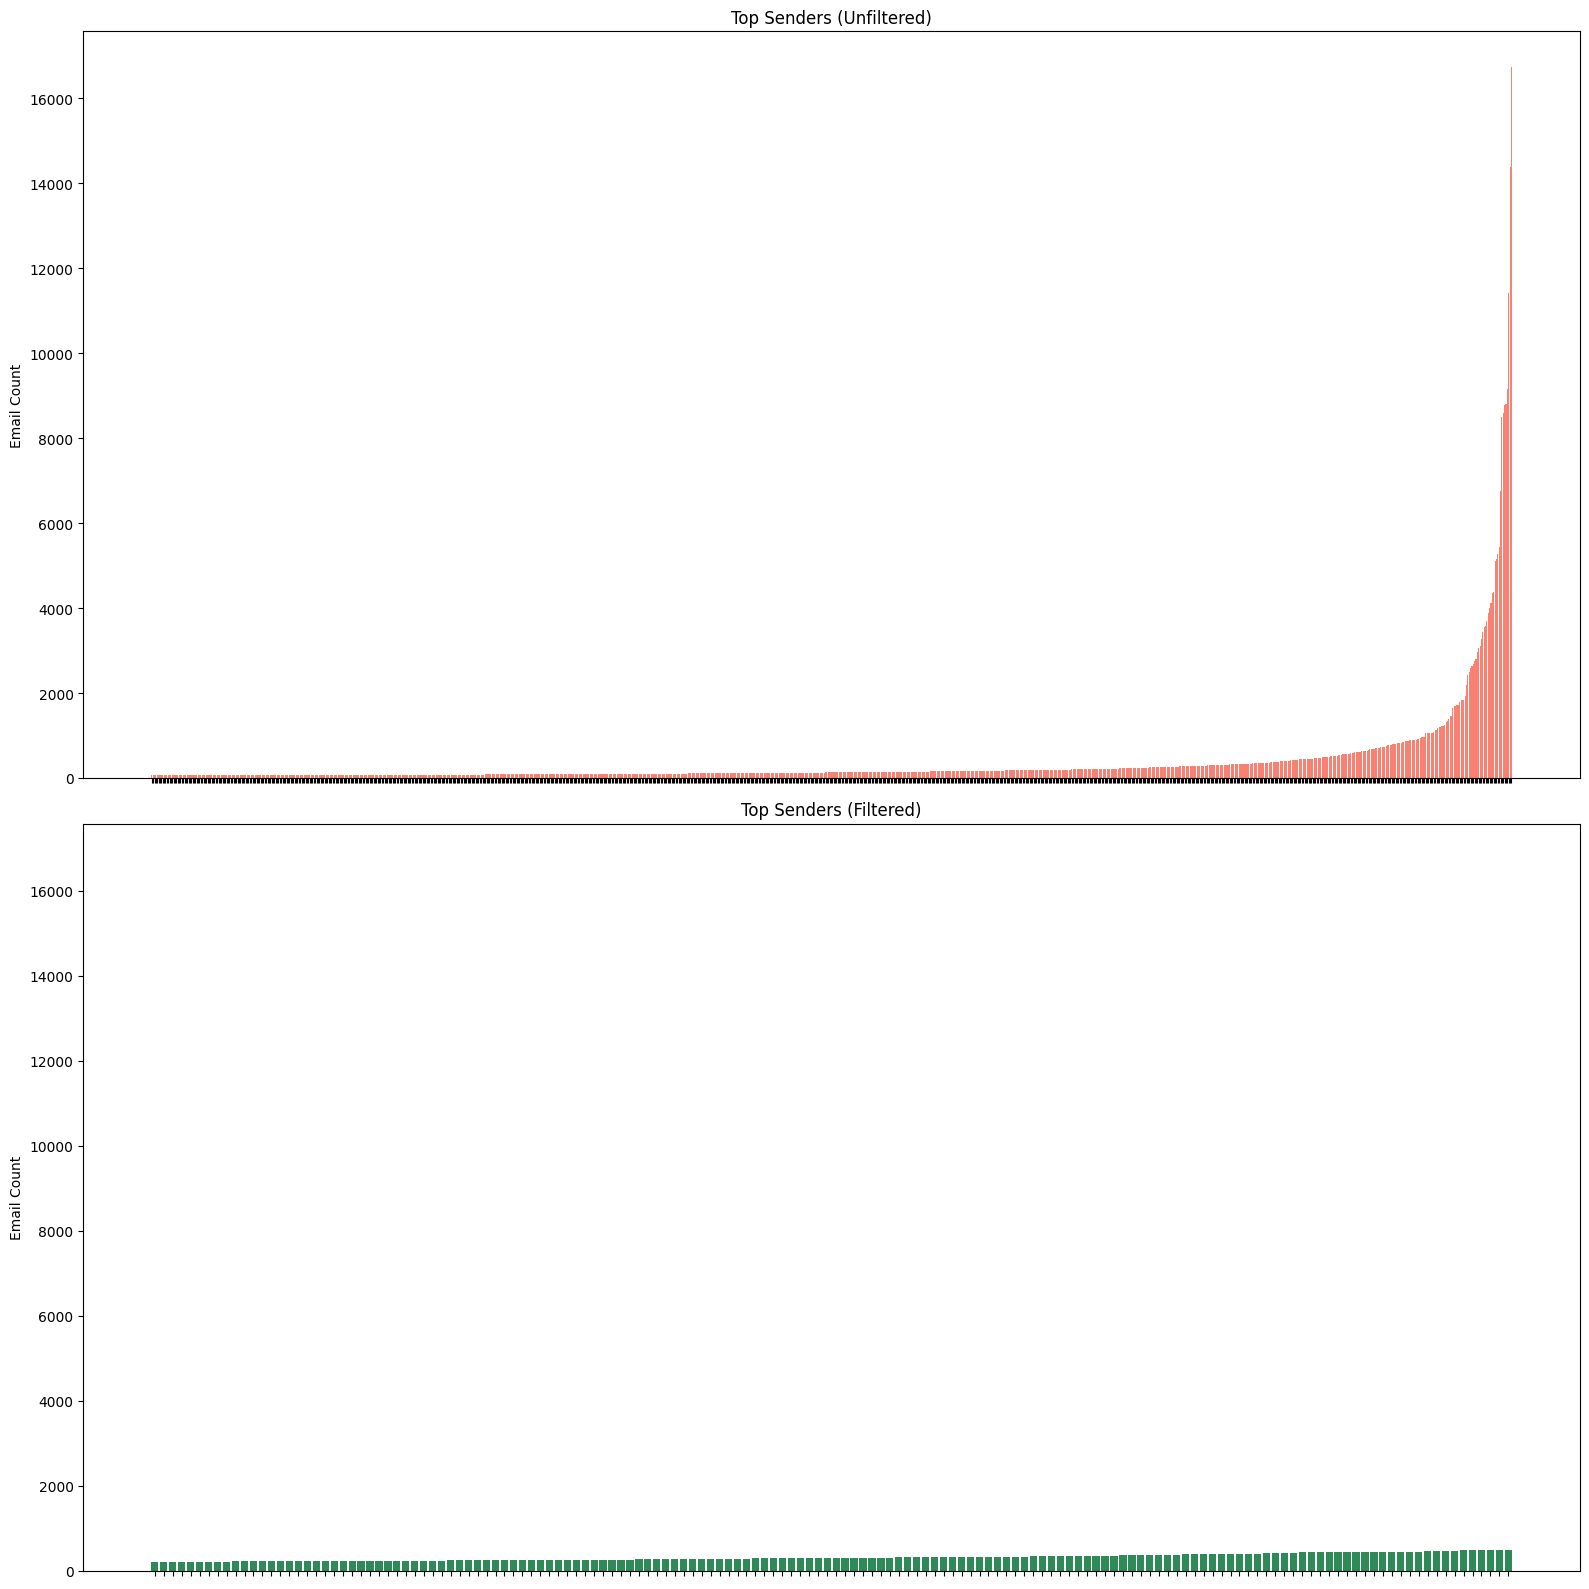

In [ ]:
# Analysis of filtered vs unfiltered data
print(f"Unfiltered: {len(x)} emails from {len(set(y))} users")
print(f"Filtered:   {len(x_filtered)} emails from {len(set(y_filtered))} users with {min_emails}-{max_emails} emails")

top_threshold = 1000 # Lower = faster charts, showing less data
# Print top filtered senders
if top_threshold > len(set(y_filtered)):
    print(f"\nFiltered senders ({len(set(y_filtered))}):")
else:
    print(f"\nFiltered senders ({top_threshold}):")
for sender, email_count in count_filtered.most_common(top_threshold):
    print(f"{sender}: {email_count} emails")

# Extract top data for plotting
top_unfiltered = count.most_common(top_threshold)
top_filtered = count_filtered.most_common(top_threshold)

# Separate into sender and count lists
senders_unf, counts_unf = zip(*top_unfiltered)
senders_filt, counts_filt = zip(*top_filtered)

# Plot data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), sharey=True)
# Unfiltered plot
ax1.bar(senders_unf[::-1], counts_unf[::-1], color='salmon')
ax1.set_title('Top Senders (Unfiltered)')
ax1.set_ylabel('Email Count')
ax1.set_xticklabels([])
# Filtered plot
ax2.bar(senders_filt[::-1], counts_filt[::-1], color='seagreen')
ax2.set_title('Top Senders (Filtered)')
ax2.set_ylabel('Email Count')
ax2.set_xticklabels([])

plt.tight_layout()
plt.show()

In [ ]:
# Encode y (senders)
y_encoded = le.fit_transform(y_filtered)

# Split Data
# Split (train+val) vs test
x_temp, x_test, y_temp, y_test = train_test_split(x_filtered, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Split train vs val
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"x_val: {x_val.shape}")

x_train: 28290
x_test: 9431
x_val: 9430


## 2.1. Processing for Non-DL models

In [ ]:
# Extra processing for non-DL models
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(x_train)
X_val   = vectorizer.transform(x_val)
X_test  = vectorizer.transform(x_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}")

X_train: (28290, 88217)
X_test: (9431, 88217)
X_val: (9430, 88217)


## 2.2. Processing for DL models

In [ ]:
# Extra processing for DL models
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>", lower=False)
tokenizer.fit_on_texts(x_train)

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq  = tokenizer.texts_to_sequences(x_test)
X_val_seq   = tokenizer.texts_to_sequences(x_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=300, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=300, padding='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=300, padding='post')

print(f"X_train_seq: {len(X_train_seq)}")
print(f"X_test_seq: {len(X_test_seq)}")
print(f"X_val_seq: {len(X_val_seq)}")
print(f"X_train_pad: {len(X_train_pad)}")
print(f"X_test_pad: {len(X_test_pad)}")
print(f"X_val_pad: {len(X_val_pad)}")

X_train_seq: 28290
X_test_seq: 9431
X_val_seq: 9430
X_train_pad: 28290
X_test_pad: 9431
X_val_pad: 9430


# 3. ML Models

## 3.1 Random Forest

In [ ]:
# Create and train the model
n = 100
r = 42

rf_model = RandomForestClassifier(n_estimators = n, random_state = r)
rf_model.fit(X_train, y_train)

# Predict
train_preds = rf_model.predict(X_train)
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)
print('model fitted')

In [2]:
# Evaluate
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Create subset confusion matrix
top_N = 16
top_class_indices = [cls for cls, _ in Counter(y_test).most_common(top_N)]
mask = np.isin(y_test, top_class_indices)

X_test_top = X_test[mask]
y_test_top = y_test[mask]
y_pred_top = rf_model.predict(X_test_top)

cm = confusion_matrix(y_test_top, y_pred_top, labels=top_class_indices)
class_labels = le.classes_[top_class_indices]

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, cmap='viridis', xticks_rotation=90)
ax.set_title(f"Confusion Matrix - Top {top_N} Senders")
plt.tight_layout()
plt.show()

# Create full confusion matrix and export to excel
y_pred_full = rf_model.predict(X_test)
cm_full = confusion_matrix(y_test, y_pred_full)
cm_df = pd.DataFrame(cm_full, index=le.classes_, columns=le.classes_)

# Export to Excel
cm_df.to_excel("confusion_matrix_full.xlsx")
print("Full cm exported to 'confusion_matrix_full.xlsx'")

NameError: name 'train_acc' is not defined

test
